In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

sys.path.append(os.path.abspath("/Users/samsongourevitch/Documents/Chlamy_Project_Github/Chlamy_project"))

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Scripts import Data_v2
from Scripts import Data_analysis_func
from Scripts import Model_checks
import seaborn as sns
from scipy.stats import multivariate_normal
from sklearn.linear_model import LinearRegression
from Scripts import Outlier_detection_v2
from Scripts import Genes_self_similarity_v2
from matplotlib_venn import venn2, venn2_circles
from Scripts import Feature_engineering
from Scripts import Clusters
from tqdm import tqdm

In [4]:
data_slopes = pd.read_csv("/Users/samsongourevitch/Documents/Chlamy_Project_Github/Chlamy_project/Data/database_phase_1_after_preprocessing_with_right_WT_07_23_2024.csv")

/var/folders/1m/j6l58hd9755c0h_89l4yckhw0000gn/T/ipykernel_48220/1644716789.py:1: DtypeWarning: Columns (381,382) have mixed types. Specify dtype option on import or set low_memory=False.
  data_slopes = pd.read_csv("/Users/samsongourevitch/Documents/Chlamy_Project_Github/Chlamy_project/Data/database_phase_1_after_preprocessing_with_right_WT_07_23_2024.csv")


In [16]:
light_regimes = ['20h_HL', '20h_ML', '2h-2h', '10min-10min', '1min-1min', '30s-30s']

In [7]:
data_slope_cluster = Outlier_detection_v2.detect_and_cluster_slopes(data_slopes, alpha=0.01)

In [20]:
gene_data = Data_v2.get_gene_data_y2(data_slopes)

/Users/samsongourevitch/Documents/Chlamy_Project_Github/Chlamy_project/Scripts/Data_v2.py:538: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_gene = data_slopes.groupby(group_cols, as_index=False).agg(aggregations)
/Users/samsongourevitch/Documents/Chlamy_Project_Github/Chlamy_project/Scripts/Data_v2.py:538: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_gene = data_slopes.groupby(group_cols, as_index=False).agg(aggregations)


In [21]:
gene_pivot = Data_v2.get_pivot_features_genes(gene_data)

In [22]:
feature_slope_columns = [col for col in gene_pivot.columns if 'slope' in col and 'std' not in col]
feature_slope_columns_std = ['slope_y2_std' + col.split('slope_y2')[1] for col in feature_slope_columns]

In [23]:
# Initialize the dictionaries
final_mutants_dict = {}
final_genes_dict = {}

# Group by mutated_genes and light_regime, count the number of mutants in cluster -1 and calculate the average of slope_y2
grouped_data = data_slope_cluster.groupby(['mutated_genes', 'light_regime']).agg(
    count=('slope_cluster_y2', lambda x: (x == -1).sum()),
    avg_slope=('slope_y2', 'mean')
).reset_index()

# Calculate the total number of mutants per gene
total_mutants_per_gene = data_slope_cluster.groupby(['mutated_genes', 'light_regime'])['mutant_ID'].size().reset_index(name='total_mutants')

# Merge the grouped data with the total mutants per gene
merged_data = pd.merge(grouped_data, total_mutants_per_gene, on=['mutated_genes', 'light_regime'])

# Calculate the proportion of mutants with the same light_regimes_non_zero list
merged_data['proportion'] = merged_data['count'] / merged_data['total_mutants']

for light_regime in merged_data['light_regime'].unique():
    # Filter genes where the same list appears for at least two-thirds of the mutants
    filtered_genes = merged_data[(merged_data['light_regime'] == light_regime) & (merged_data['proportion'] >= 1) & (merged_data['total_mutants'] >= 2)]

    # Extract the final genes meeting the condition
    final_genes = filtered_genes['mutated_genes'].unique()
    final_genes_dict[light_regime] = final_genes

    # Extract the mutants belonging to these genes from the original DataFrame
    final_filtered_mutants = data_slope_cluster[data_slope_cluster['mutated_genes'].isin(final_genes)]
    final_filtered_mutants['source_df'] = light_regime
    final_mutants_dict[light_regime] = final_filtered_mutants

/var/folders/1m/j6l58hd9755c0h_89l4yckhw0000gn/T/ipykernel_48220/2031864912.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_filtered_mutants['source_df'] = light_regime
/var/folders/1m/j6l58hd9755c0h_89l4yckhw0000gn/T/ipykernel_48220/2031864912.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_filtered_mutants['source_df'] = light_regime
/var/folders/1m/j6l58hd9755c0h_89l4yckhw0000gn/T/ipykernel_48220/2031864912.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [24]:
# pivot merged_data
merged_data_pivot = merged_data.pivot(index='mutated_genes', columns='light_regime', values='proportion').reset_index()

In [25]:
# merge the merged_data_pivot with the gene_pivot on the key mutated_genes
gene_pivot_merged = gene_pivot.merge(merged_data_pivot, on='mutated_genes', how='left')

In [27]:
gene_pivot_merged = gene_pivot_merged[['mutated_genes'] + feature_slope_columns + light_regimes]

In [28]:
# fill the NaN values with 0 but only for the columns 10min-10min, 1min-1min, 20h_HL, 20h_ML, 2h-2h, 30s-30s
for light_regime in light_regimes:
    gene_pivot_merged[light_regime].fillna(0, inplace=True)

/var/folders/1m/j6l58hd9755c0h_89l4yckhw0000gn/T/ipykernel_48220/693098822.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  gene_pivot_merged[light_regime].fillna(0, inplace=True)


In [ ]:
# if we want to use the hand picked genes

# # read the .txt file containing the gene names
# interesting_gene_dict = {}
# types = ['high_light_sensitive_frequency_independant', 'high_light_high_frequency_sensitivity', 'high_frequency_sensitivity', 'high_light']
# for type in types:
#     file_path = '/Users/samsongourevitch/Documents/Chlamy_Project_Github/Chlamy_project/' + type + '.txt'
#     try:
#         with open(file_path, 'r') as file:
#             contents = file.read()
#             if contents:
#                 interesting_genes = contents.splitlines()
#             else:
#                 print("File is empty.")
#     except Exception as e:
#         print(f"An error occurred: {e}")
#     interesting_gene_dict[type] = interesting_genes

# # add a column to result_df that indicates for which type of gene the gene is
# gene_pivot['gene_type'] = 'other'
# for type, genes in interesting_gene_dict.items():
#     gene_pivot.loc[gene_pivot['mutated_genes'].isin(genes), 'gene_type'] = type

# # if the gene starts with WT the type is WT
# gene_pivot.loc[gene_pivot['mutated_genes'].str.startswith('WT'), 'gene_type'] = 'WT'

In [29]:
# if we want to use the semi hand picked genes

gene_pivot_merged_na = gene_pivot_merged.dropna()
merged_data_pivot_na = merged_data_pivot.dropna()

# Conditions
def classify_genes(row):
    if (row['20h_HL'] > 0.6 and row['20h_ML'] > 0.6 and
        row[['2h-2h', '10min-10min', '1min-1min', '30s-30s']].max() < 0.3):
        return 'continuous_light_sensitive'
    
    if (row['20h_HL'] == 1 and row[['20h_ML', '2h-2h', '10min-10min', '1min-1min', '30s-30s']].max() < 0.3):
        return 'HL_sensitive'
    
    for condition in ['20h_HL', '20h_ML', '2h-2h', '10min-10min', '1min-1min', '30s-30s']:
        if (row[condition] == 1 and row[light_regimes].drop(condition).max() < 0.3):
            return condition

    if (row[['10min-10min', '1min-1min', '30s-30s']].ge(1).sum() >= 2 and
        row[['20h_HL', '20h_ML', '2h-2h']].max() < 0.3):
        return 'high_frequency_sensitive'

    if (row['20h_HL'] == 1 and row[['10min-10min', '1min-1min', '30s-30s']].max() == 1):
        return 'high_light_high_frequency'
    if row['mutated_genes'].startswith('WT'):
        return 'WT'

    return 'other'

# Apply classification
gene_pivot_merged_na['gene_type'] = gene_pivot_merged_na.apply(classify_genes, axis=1)

/var/folders/1m/j6l58hd9755c0h_89l4yckhw0000gn/T/ipykernel_48220/539584524.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_pivot_merged_na['gene_type'] = gene_pivot_merged_na.apply(classify_genes, axis=1)


In [30]:
gene_pivot_merged_na['gene_type'].value_counts()

gene_type
other                         2845
WT                             128
high_light_high_frequency      103
HL_sensitive                    65
1min-1min                       65
high_frequency_sensitive        50
30s-30s                         17
10min-10min                     17
20h_ML                           5
2h-2h                            4
continuous_light_sensitive       1
Name: count, dtype: int64

In [31]:
std_normalized = gene_pivot[feature_slope_columns_std].apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)
std_normalized['average_std'] = std_normalized.mean(axis=1)

Accuracy: 1.0


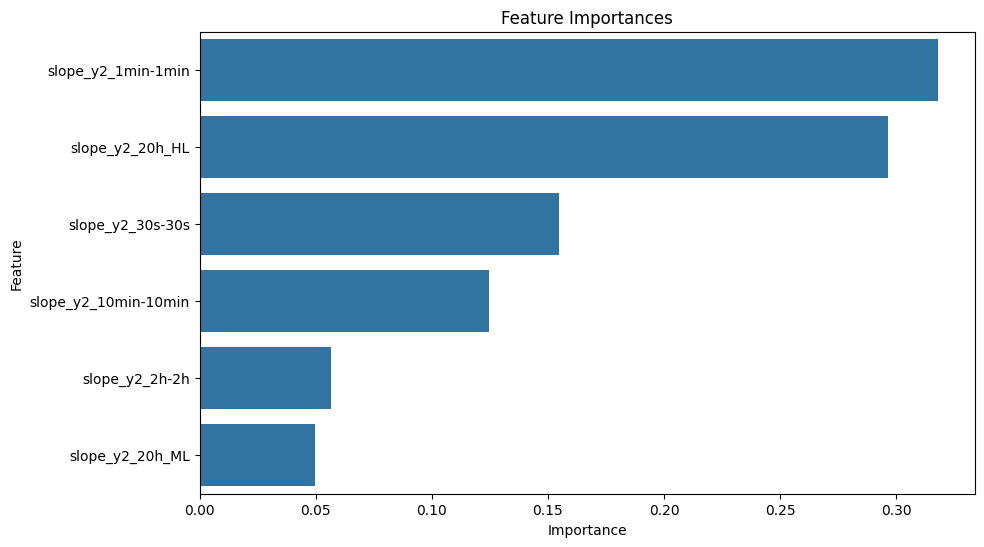

In [32]:
# train a model to predict the gene type

gene_df_filtered = gene_pivot_merged_na[gene_pivot_merged_na['gene_type'] != 'other']

# Define the features and target
X = gene_df_filtered[feature_slope_columns]
y = gene_df_filtered['gene_type']

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=0)

# Train a Random Forest classifier
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(X_train, y_train)

# Evaluate the model
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")

# Get feature importances
importances = model.feature_importances_
importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances_df)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [33]:
# use the model to predict the gene type of the genes in result_df

gene_pivot['predicted_gene_type'] = model.predict(gene_pivot[feature_slope_columns])

# add the confidence of the prediction
gene_pivot['confidence'] = model.predict_proba(gene_pivot[feature_slope_columns]).max(axis=1)

# # adjust the confidence of the prediction based on the std of the slope
# std_normalized = gene_pivot[feature_slope_columns_std].apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)
# std_normalized['average_std'] = std_normalized.mean(axis=1)

# gene_pivot['confidence'] = gene_pivot['confidence'] * (1 - std_normalized['average_std'])

In [34]:
# result_df['predicted_gene_type'].value_counts()
gene_pivot['predicted_gene_type'].value_counts()

predicted_gene_type
WT                            1864
1min-1min                      859
high_light_high_frequency      307
HL_sensitive                   301
high_frequency_sensitive       165
30s-30s                        108
10min-10min                     85
20h_ML                          35
2h-2h                           16
continuous_light_sensitive       1
Name: count, dtype: int64

In [41]:
gene_pivot.to_csv("/Users/samsongourevitch/Documents/Chlamy_Project_Github/Chlamy_project/Data/gene_info_with_predicted_gene_type.csv", index=False)

In [35]:
def custom_sort_key(value):
    desired_order = ['20h_HL', '20h_ML', '2h-2h', '10min-10min', '1min-1min', '30s-30s']
    # desired_order = ['20h_HL', '20h_ML', 'low_2h-2h', 'high_2h-2h', 'low_10min-10min', 'high_10min-10min', 'low_1min-1min', 'high_1min-1min', 'low_30s-30s', 'high_30s-30s']
    # Create a dictionary to map each value to its position in the desired order
    order_map = {value: index for index, value in enumerate(desired_order)}
    return order_map.get(value, len(desired_order))

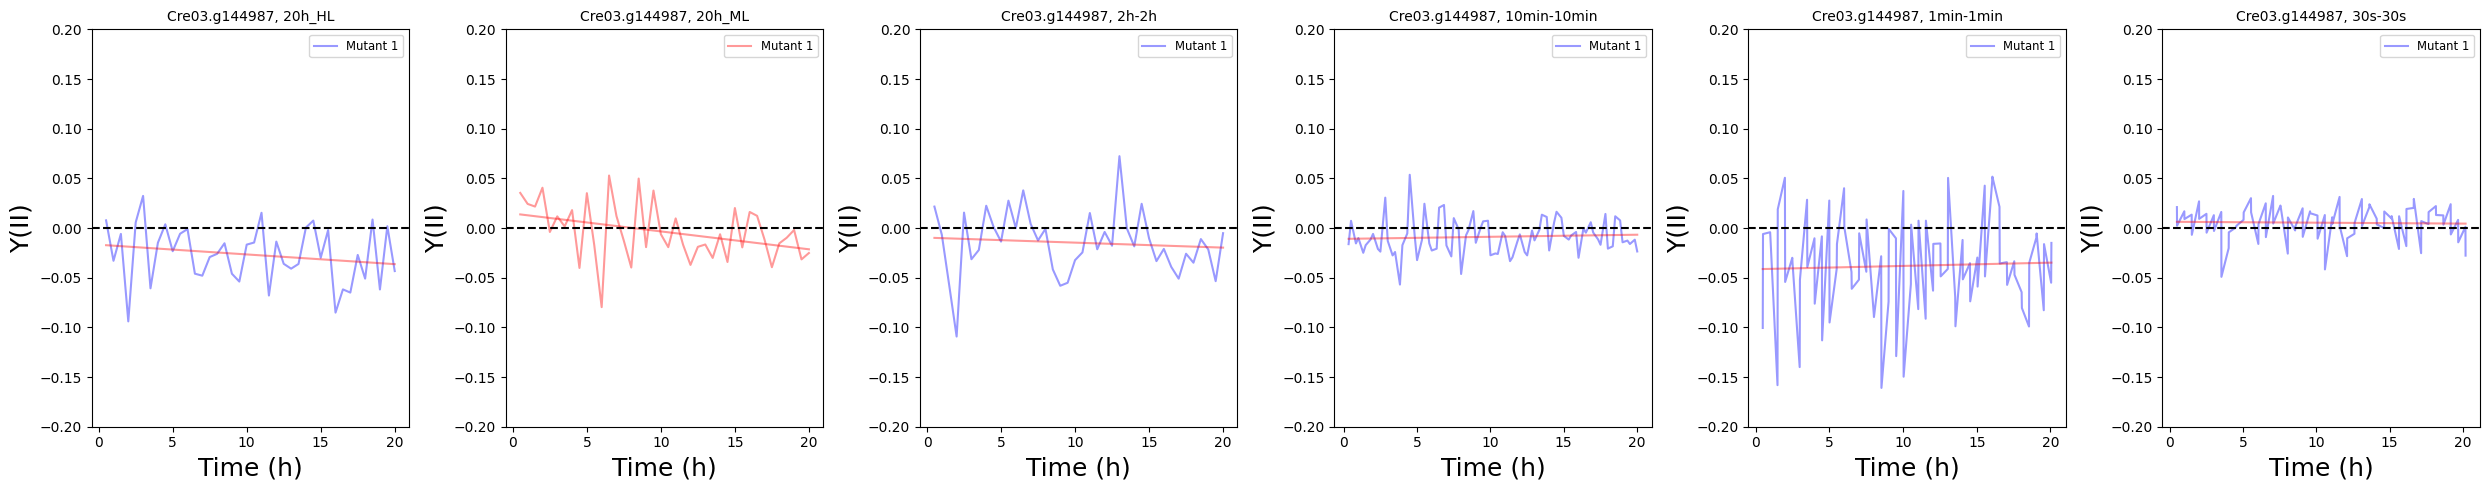

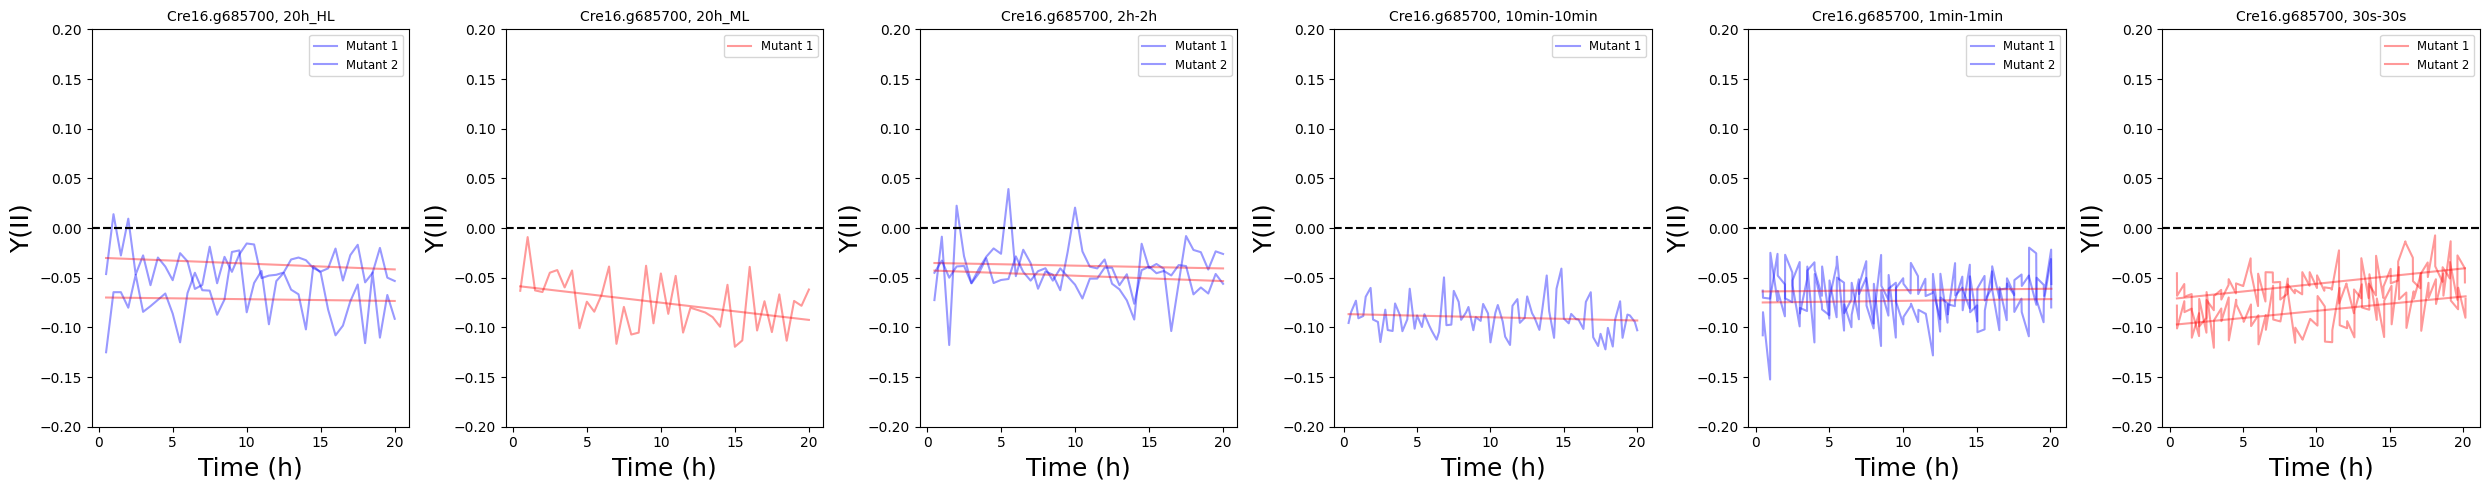

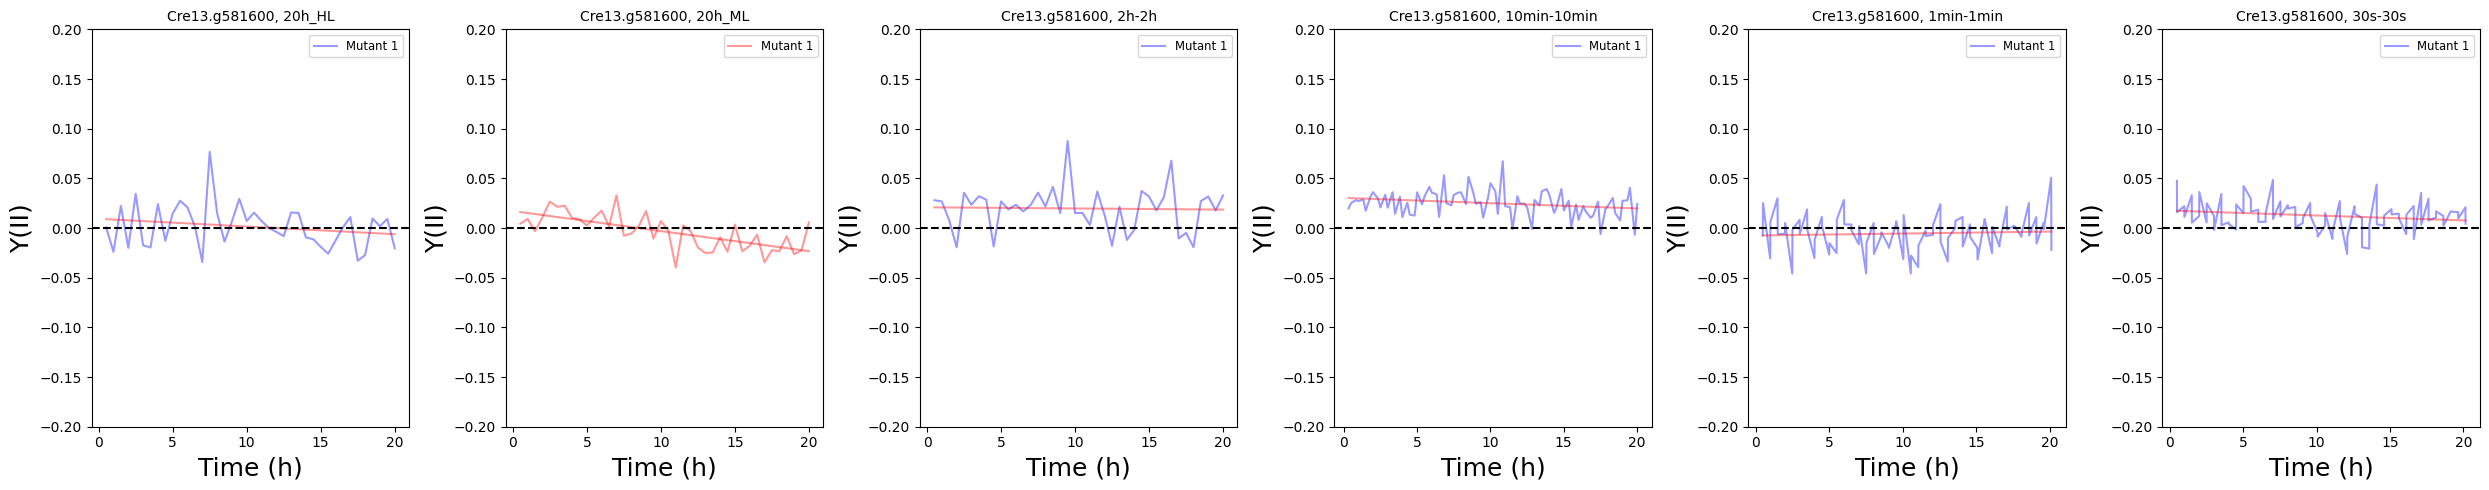

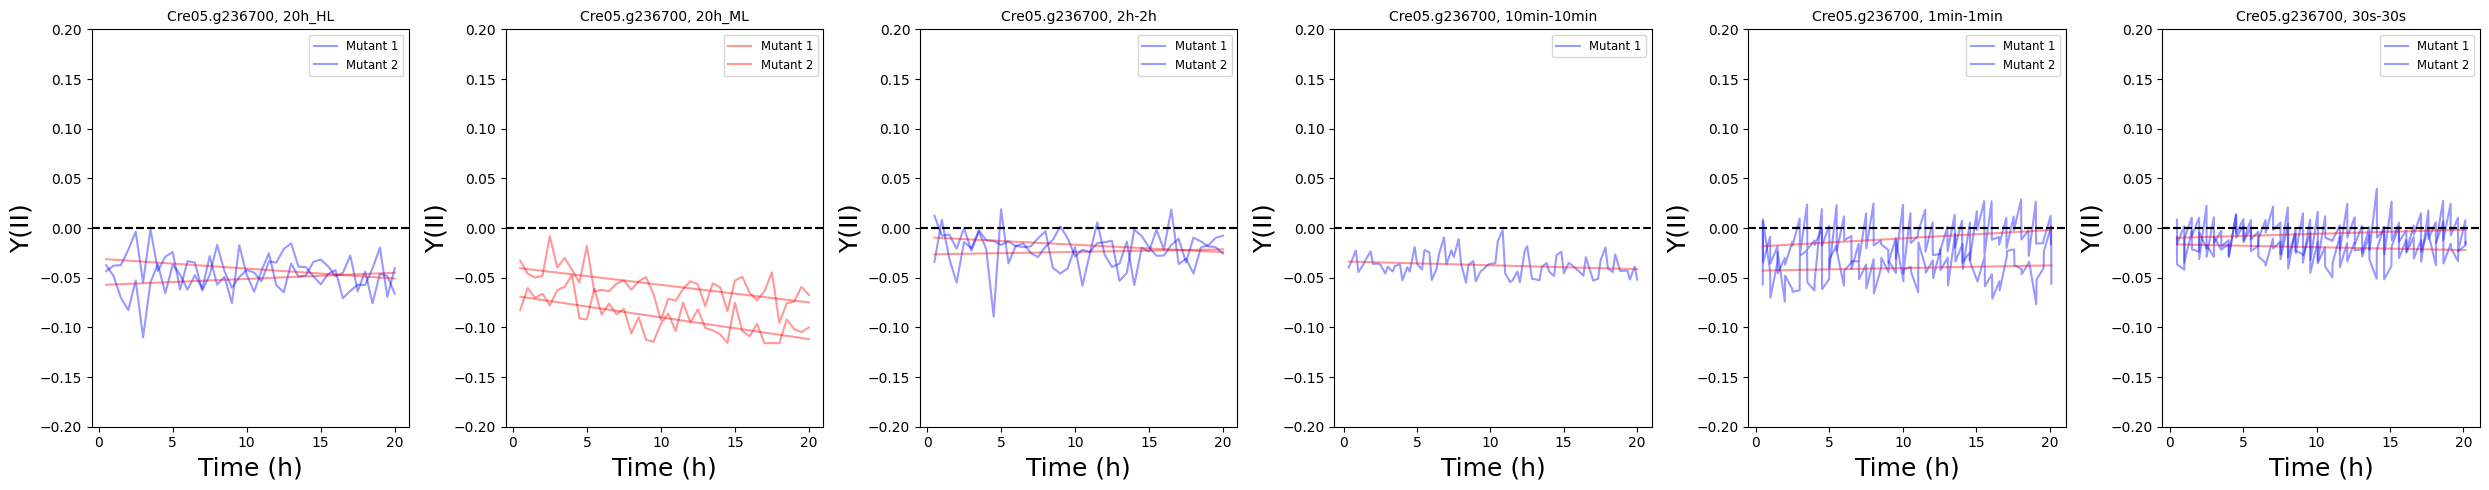

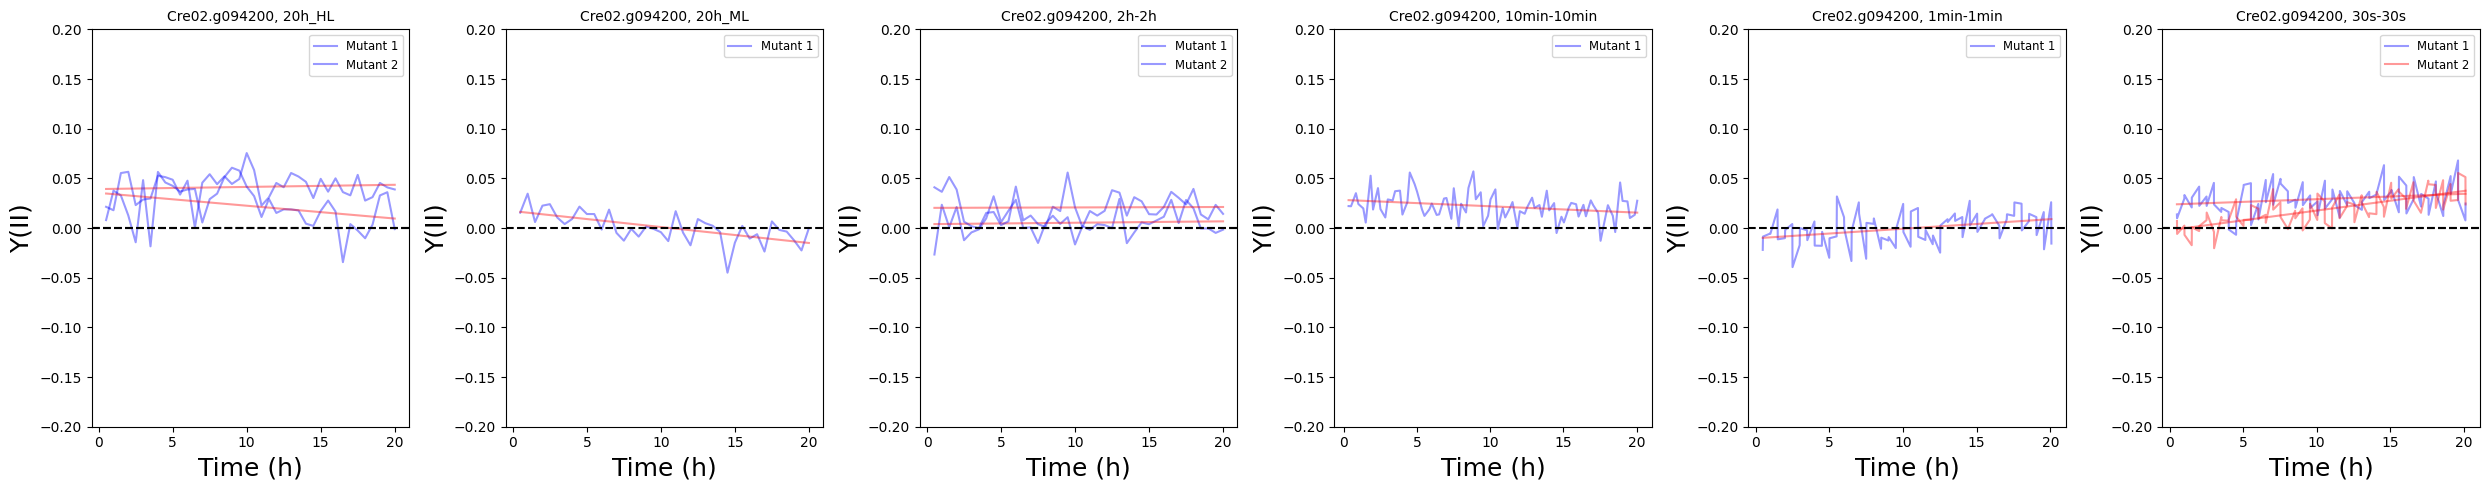

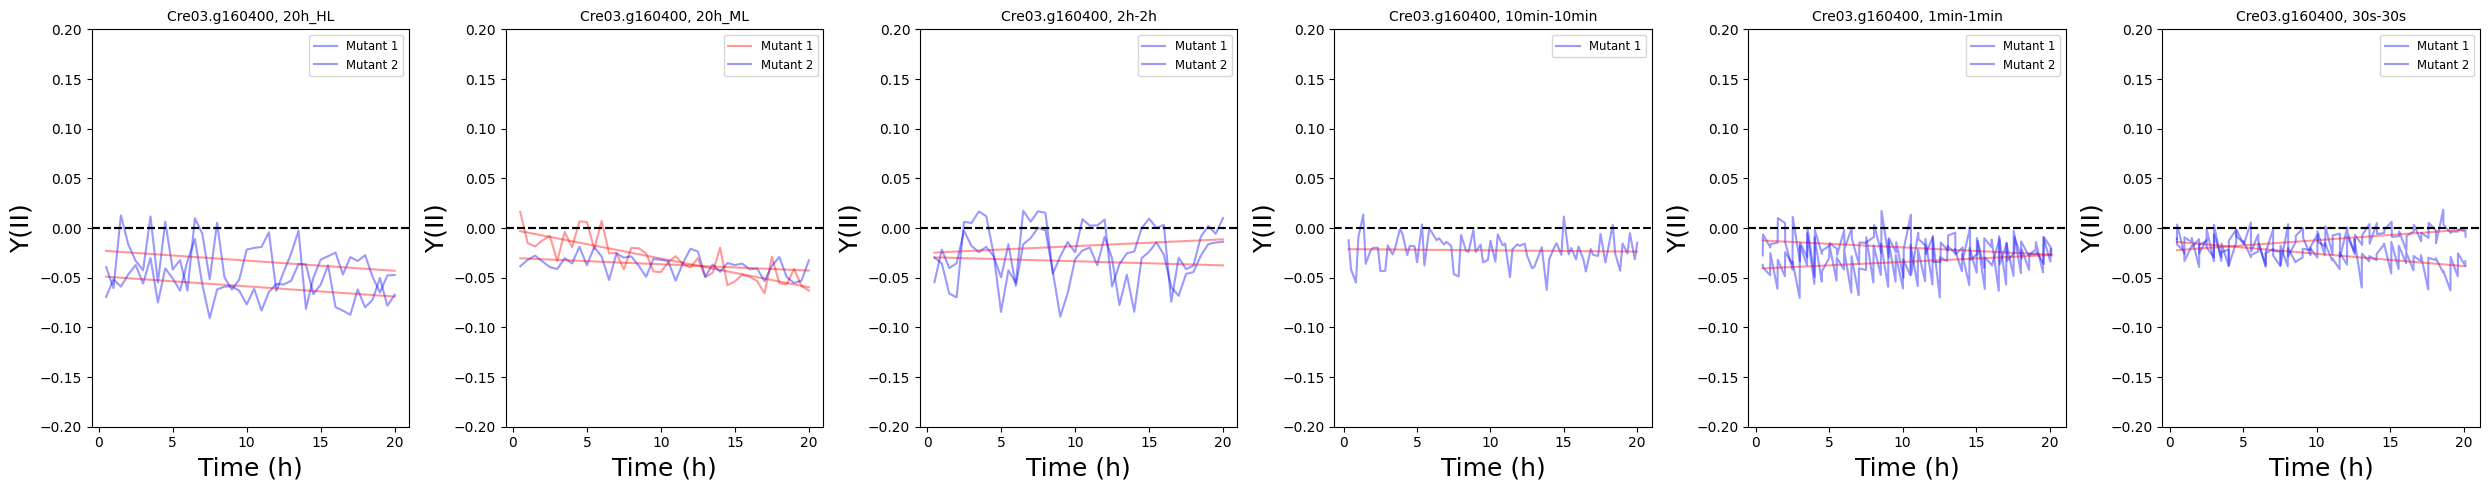

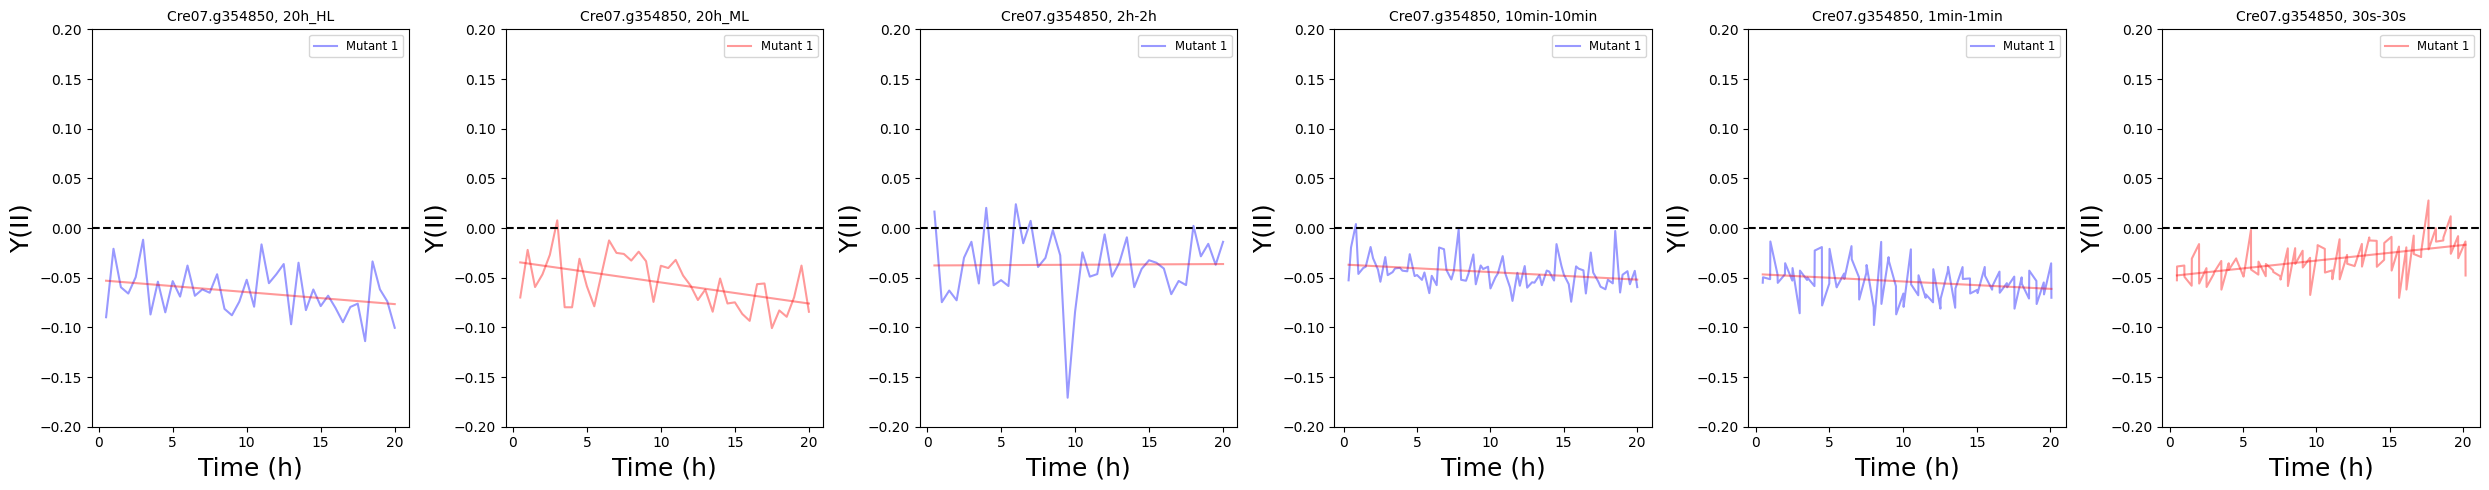

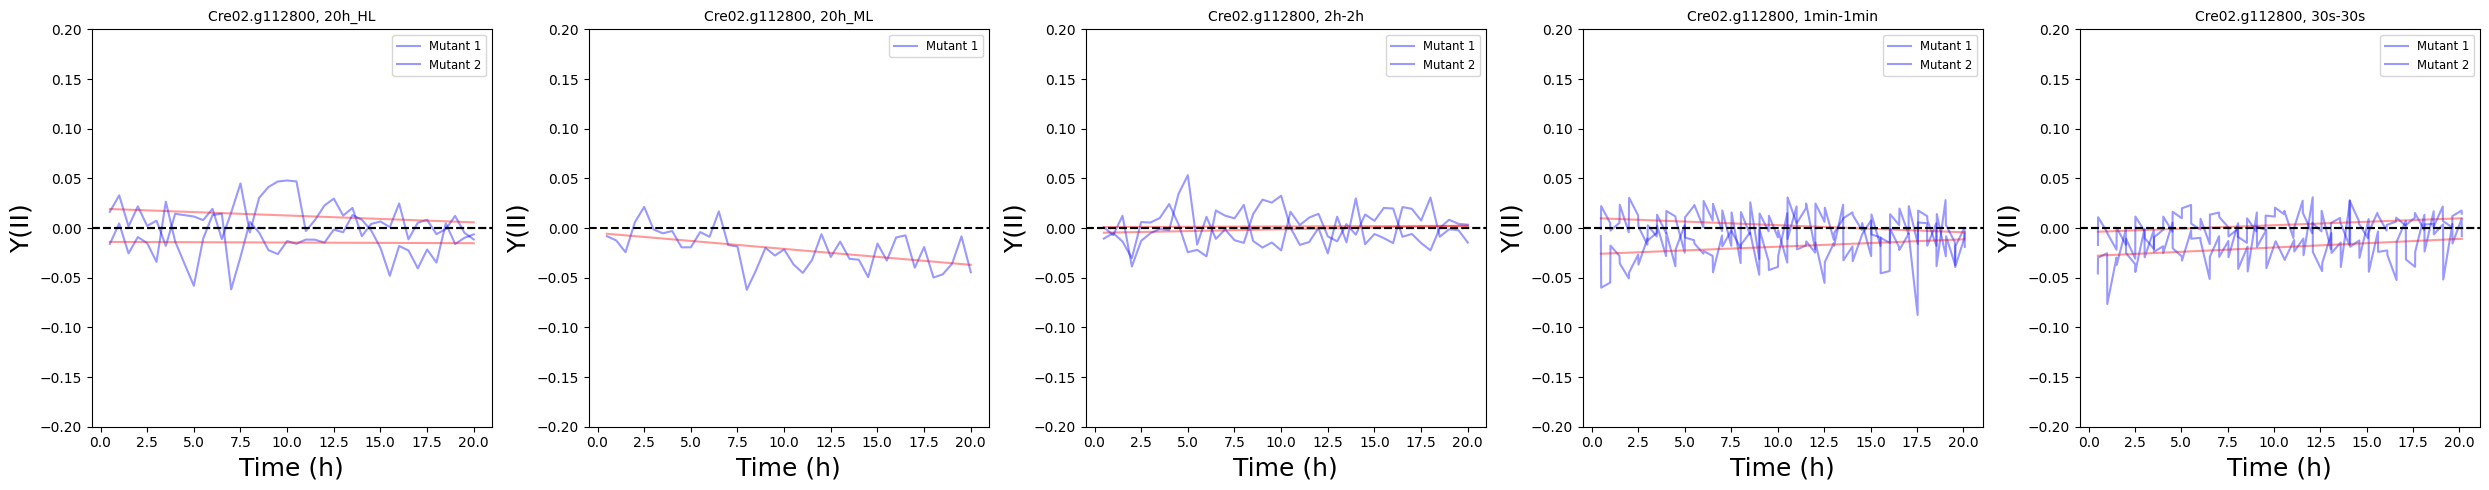

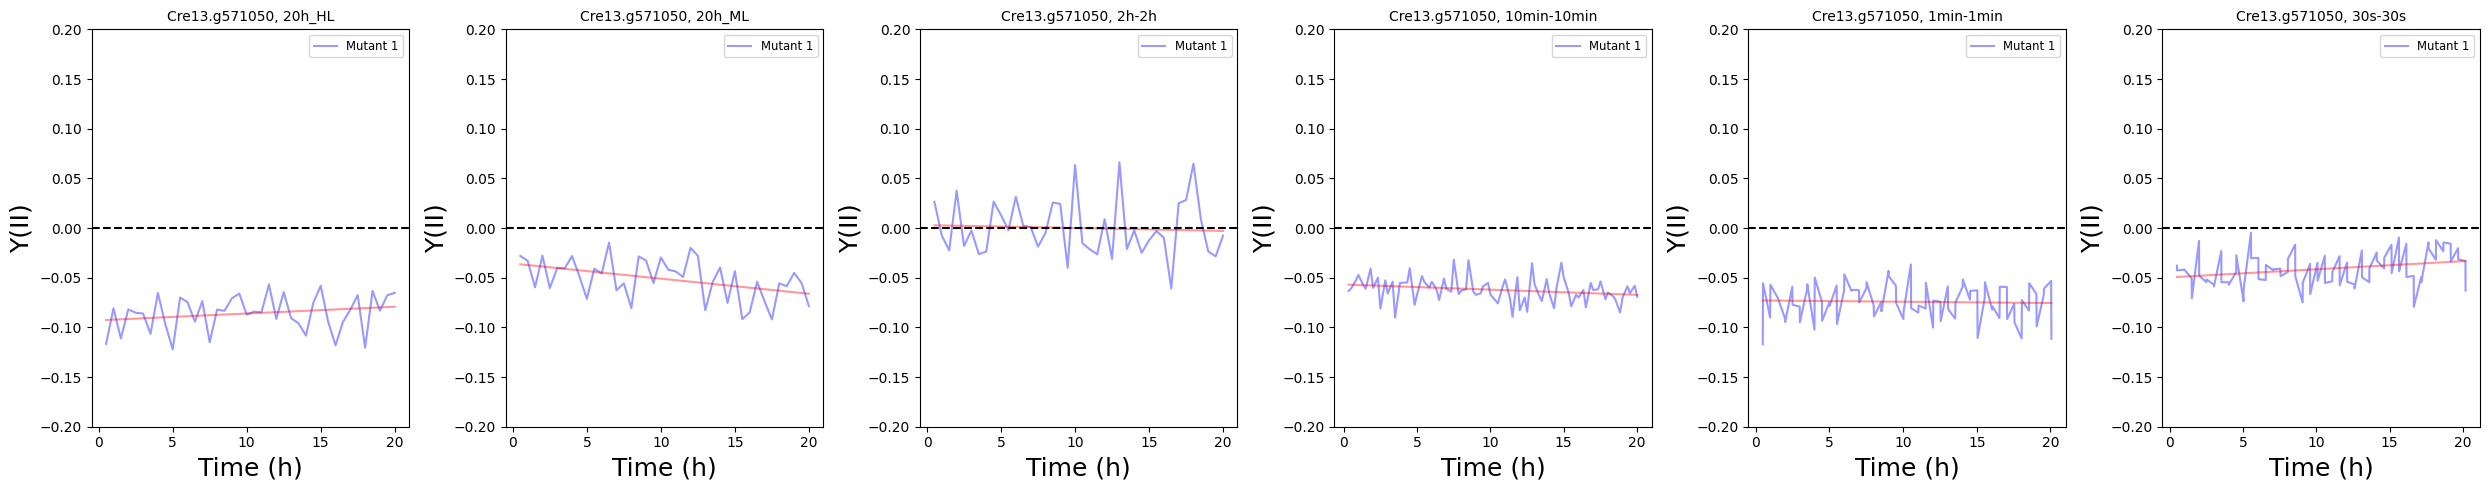

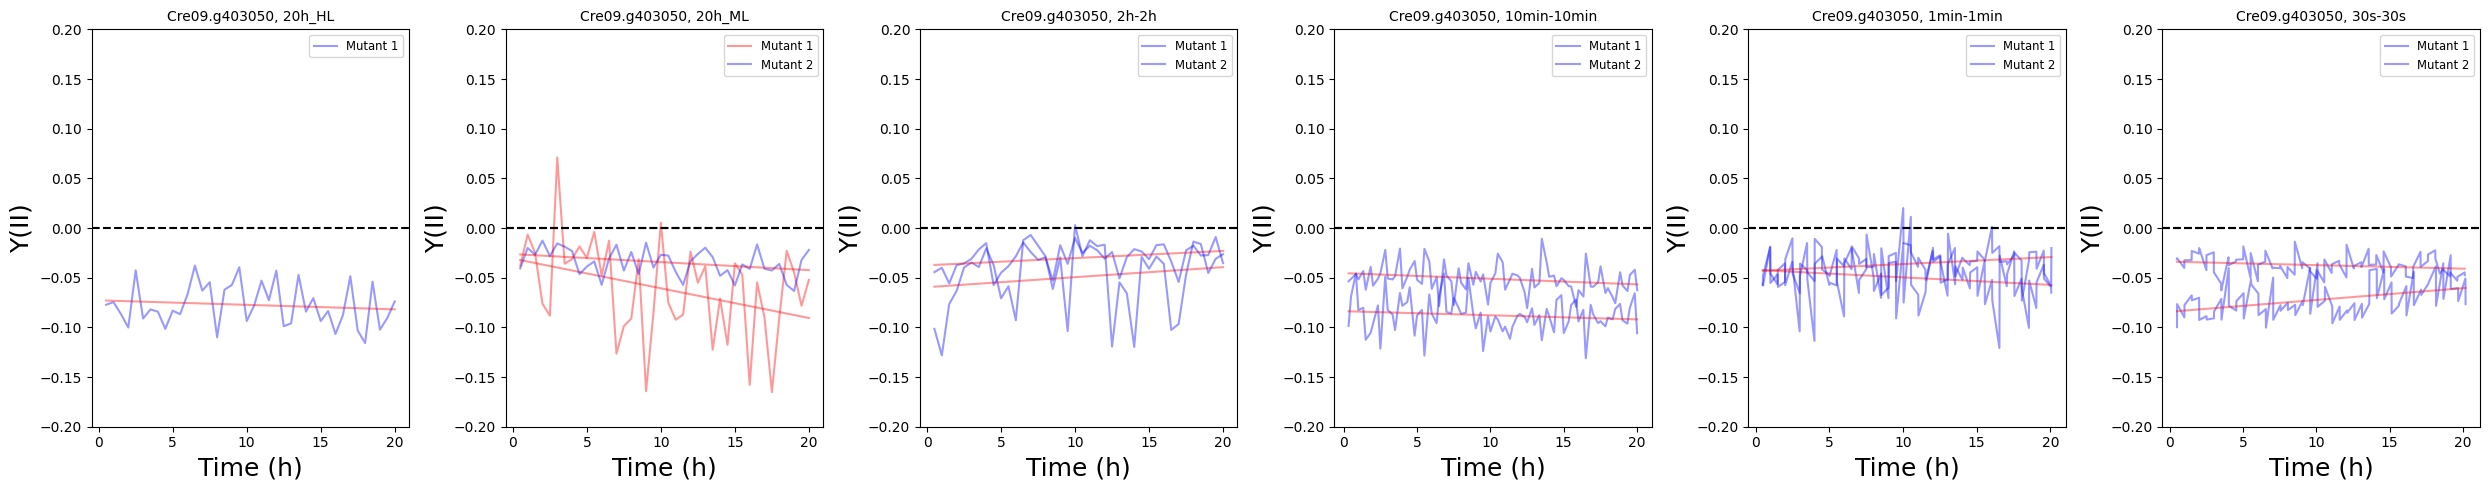

In [39]:
elapsed_time_columns = [col for col in data_slope_cluster.columns if 'elapsed_time' in col]
already_seen_genes = []

y = 'y2'

for i in range(10):
# # for i in range(10):
    gene_of_interest = gene_pivot[gene_pivot['predicted_gene_type'] == '20h_ML'].sort_values(by='confidence', ascending=False)['mutated_genes'].values[i]
    if gene_of_interest in already_seen_genes or gene_of_interest == 'special_mutant':
        continue
    already_seen_genes.append(gene_of_interest)

    # Sample array containing some of the values
    # light_regimes = data_slopes[(data_slopes['mutant_ID'] == mutant_of_interest)]['light_regime'].unique()
    light_regimes = data_slope_cluster[(data_slope_cluster['mutated_genes'] == gene_of_interest)]['light_regime'].unique()

    # Sort the array using the custom sort key
    sorted_light_regimes = sorted(light_regimes, key=custom_sort_key)
    # titles = ['Y(II) for gene ' + str(gene_of_interest) + ' in ' + light for light in sorted_light_regimes]
    titles = [str(gene_of_interest) + ', ' + light for light in sorted_light_regimes]

    # Prepare subplot layout
    fig, axes = plt.subplots(1, len(titles), figsize=(25, 5))

    # Iterate over light regimes and plot Y(II) values
    for j, (light_regime, title) in enumerate(zip(sorted_light_regimes, titles)):
        # Filter data for the current gene and light regime
        filtered_data = data_slope_cluster[(data_slope_cluster['mutated_genes'] == gene_of_interest) & 
                                            (data_slope_cluster['light_regime'] == light_regime)]
        
        # Extract Y(II) values and plot each line
        y2_values = filtered_data.filter(regex=r'^'+y+'_\d+$').dropna(axis=1).values

        for k in range(y2_values.shape[0]):
            if light_regime in ['high_2h-2h', 'high_10min-10min', 'high_1min-1min', 'high_30s-30s']:
                elapsed_time = filtered_data[elapsed_time_columns].dropna(axis=1).values[k][1:]
            elif light_regime in ['low_2h-2h', 'low_10min-10min', 'low_1min-1min', 'low_30s-30s']:
                elapsed_time = filtered_data[elapsed_time_columns].dropna(axis=1).values[k][:-1]
            else:
                elapsed_time = filtered_data[elapsed_time_columns].dropna(axis=1).values[k][1:-1]
            if filtered_data['slope_cluster_' + y].values[k] != 0:
                color = 'r'
            else:
                color = 'b'
            # color = 'b'
            try :
                axes[j].plot(elapsed_time, y2_values[k], c=color, alpha=0.4, label='Mutant {}'.format(k+1))
                # plot the linear regression
                model = LinearRegression()
                model.fit(elapsed_time.reshape(-1, 1), y2_values[k])
                y_pred = model.predict(elapsed_time.reshape(-1, 1))
                axes[j].plot(elapsed_time, y_pred, c='r', alpha=0.4)
                axes[j].axhline(y=0, color='black', linestyle='--')
                # Set title and other plot properties
                axes[j].set_title(title, fontsize=10)
                # axes[j].set_title(light_regime)
                axes[j].set_xlabel('Time (h)', fontsize=18)
                axes[j].set_ylabel('Y(II)', fontsize=18)
                axes[j].set_ylim(-0.2, 0.2)
                axes[j].legend(loc='upper right', fontsize='small')
            except:
                continue

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

In [37]:
light_regime_to_int = {'20h_HL': 0, '20h_ML': 1, '2h-2h': 2, '10min-10min': 3, '1min-1min': 4, '30s-30s': 5}
y2_cols = [col for col in gene_data.columns if col.startswith('y2_')]

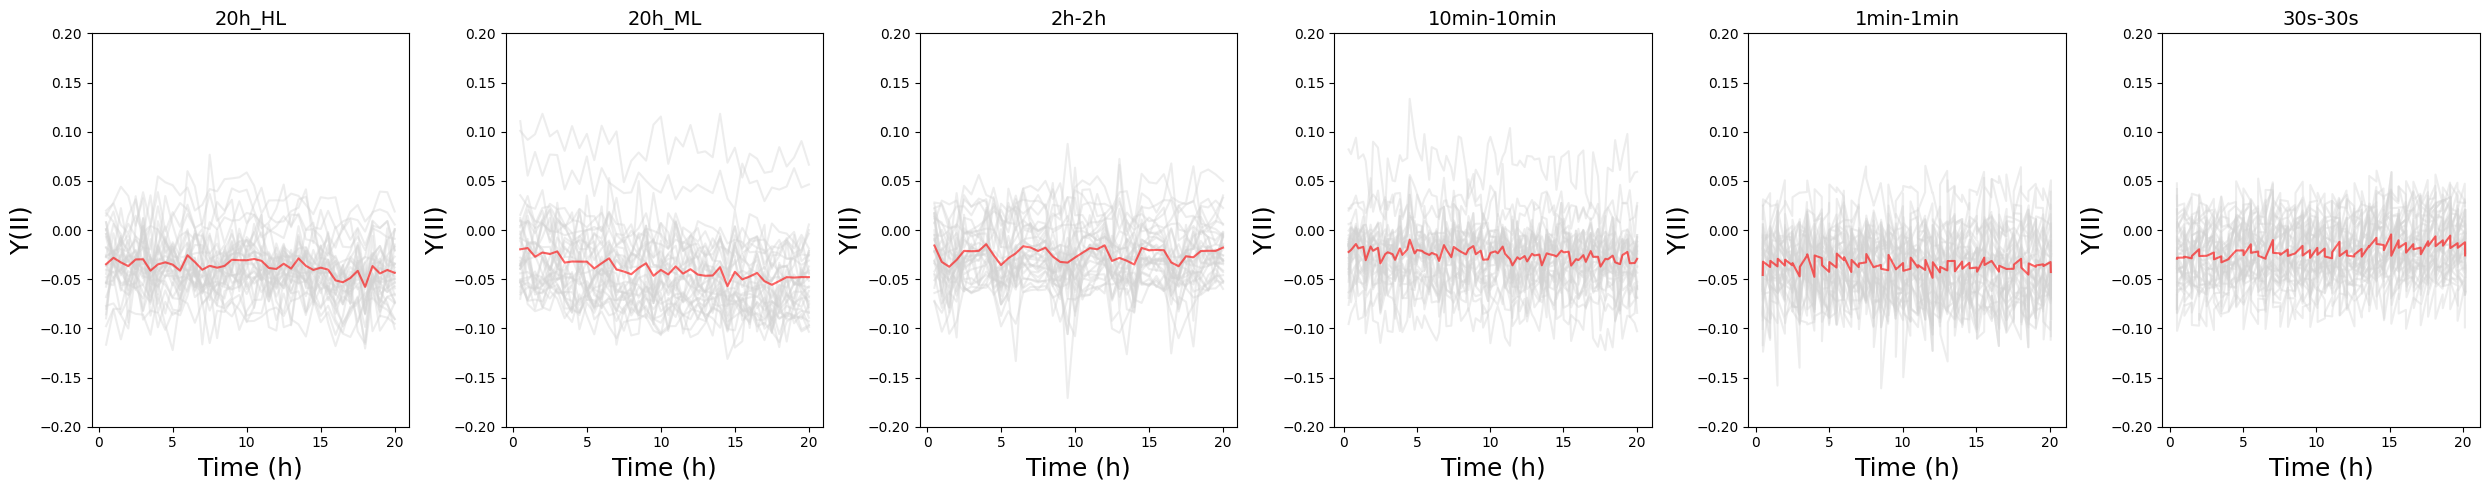

In [38]:
gene_type = '20h_ML'

fig, axes = plt.subplots(1, 6, figsize=(25, 5))

already_seen_genes = []

# Loop through each gene of interest
for i in range(gene_pivot[gene_pivot['predicted_gene_type'] == gene_type].sort_values(by='confidence', ascending=False)['mutated_genes'].nunique()):
    gene_of_interest = gene_pivot[gene_pivot['predicted_gene_type'] == gene_type].sort_values(by='confidence', ascending=False)['mutated_genes'].values[i]
    already_seen_genes.append(gene_of_interest)
    light_regimes = data_slope_cluster[data_slope_cluster['mutated_genes'] == gene_of_interest]['light_regime'].unique()
    sorted_light_regimes = sorted(light_regimes, key=custom_sort_key)

    # Plot each light regime for the gene
    for light_regime in sorted_light_regimes:
        j = light_regime_to_int[light_regime]
        filtered_data = gene_data[(gene_data['mutated_genes'] == gene_of_interest) & 
                                  (gene_data['light_regime'] == light_regime)]
        
        y2_values = filtered_data.filter(regex=r'^' + y + '_\d+$').dropna(axis=1).values[0]
        elapsed_time = filtered_data[elapsed_time_columns].dropna(axis=1).values[0][1:-1]

        # Plotting on the rightmost subplot (axes[-1]) for all genes
        try:
            # Plot the individual gene with a lighter color
            axes[j].plot(elapsed_time, y2_values, c='lightgrey', alpha=0.4)

            # Set axis labels and limits
            axes[j].set_xlabel('Time (h)', fontsize=18)
            axes[j].set_ylabel('Y(II)', fontsize=18)
            axes[j].set_ylim(-0.2, 0.2)

        except Exception as e:
            print(f"Error plotting gene {gene_of_interest} for light regime {light_regime}: {e}")
            continue

genes_of_interest = gene_pivot[gene_pivot['predicted_gene_type'] == gene_type].sort_values(by='confidence', ascending=False)['mutated_genes'].unique()

# get the average of all the genes
gene_data_filtered = gene_data[gene_data['mutated_genes'].isin(genes_of_interest)]
gene_data_filtered = gene_data_filtered[['light_regime'] + y2_cols + ['slope_y2'] + elapsed_time_columns].groupby(['light_regime']).mean().reset_index()

# plot the average of all the genes on the same figure

for light_regime in gene_data_filtered['light_regime'].unique():
    j = light_regime_to_int[light_regime]
    filtered_data = gene_data_filtered[gene_data_filtered['light_regime'] == light_regime]
    y2_values = filtered_data[y2_cols].values[0]
    elapsed_time = filtered_data[elapsed_time_columns].values[0][1:-1]
    color = 'r'
    axes[j].plot(elapsed_time, y2_values, c=color, alpha=0.6, label='Average of all genes')
    axes[j].set_title(light_regime, fontsize=14)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()